# Light pipes

### Instala dependencias

In [31]:
!pip install lightpipes


###Genera dataset haz laser con perturbaciones en intensidad: entrenamiento y evaluación

Generating intensity profiles: 100%|██████████| 1000/1000 [00:00<00:00, 2025.30it/s]


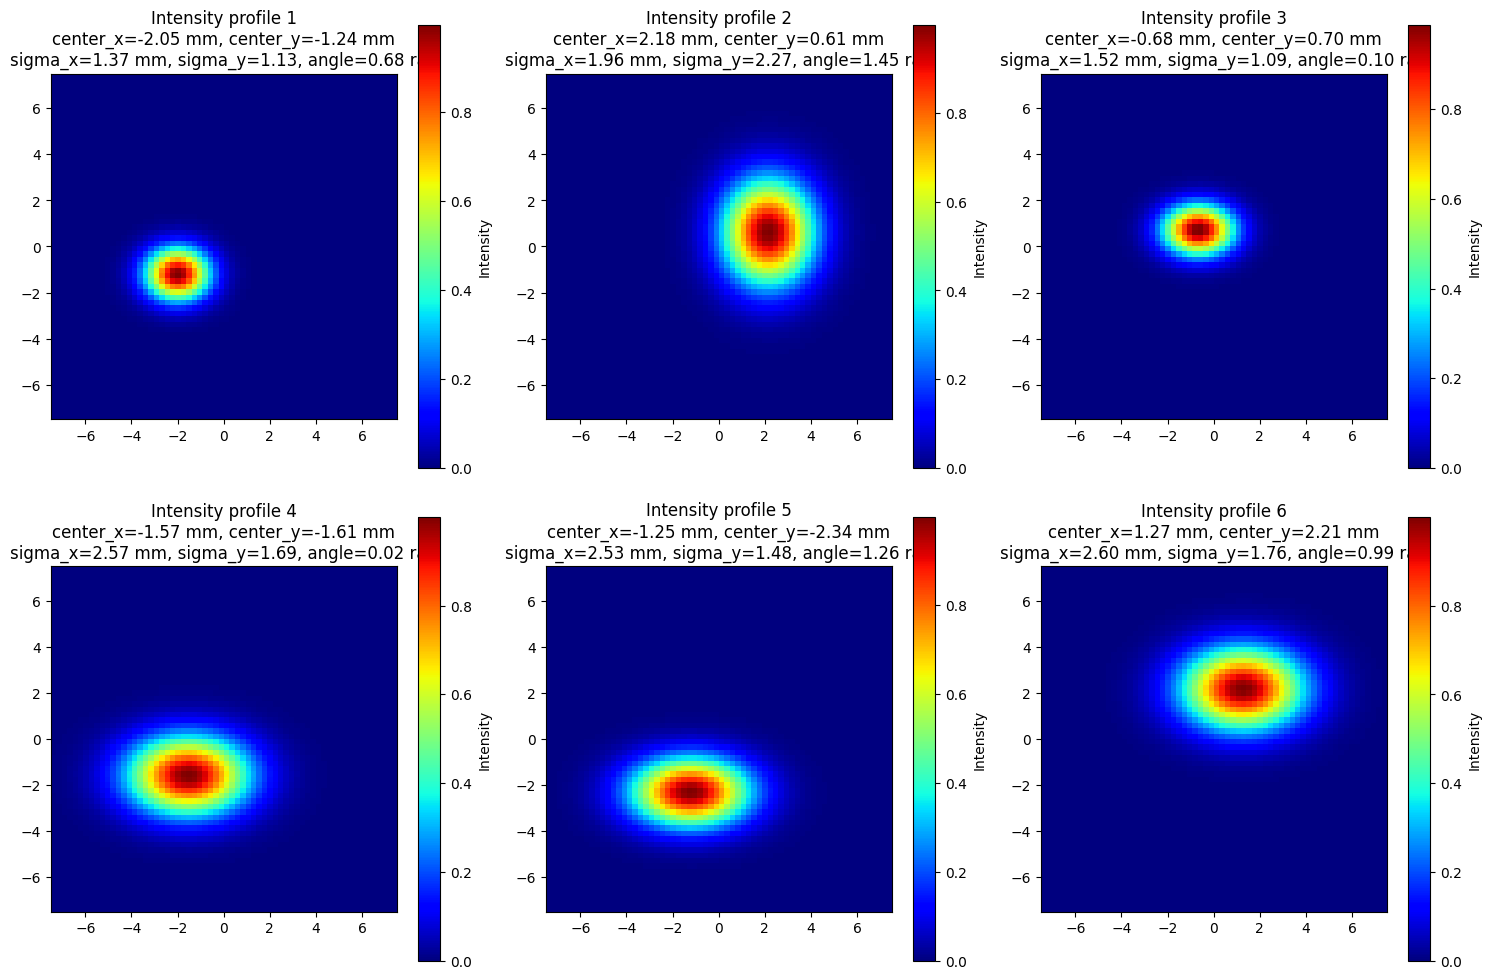

Generating intensity profiles: 100%|██████████| 1000/1000 [00:00<00:00, 1999.73it/s]


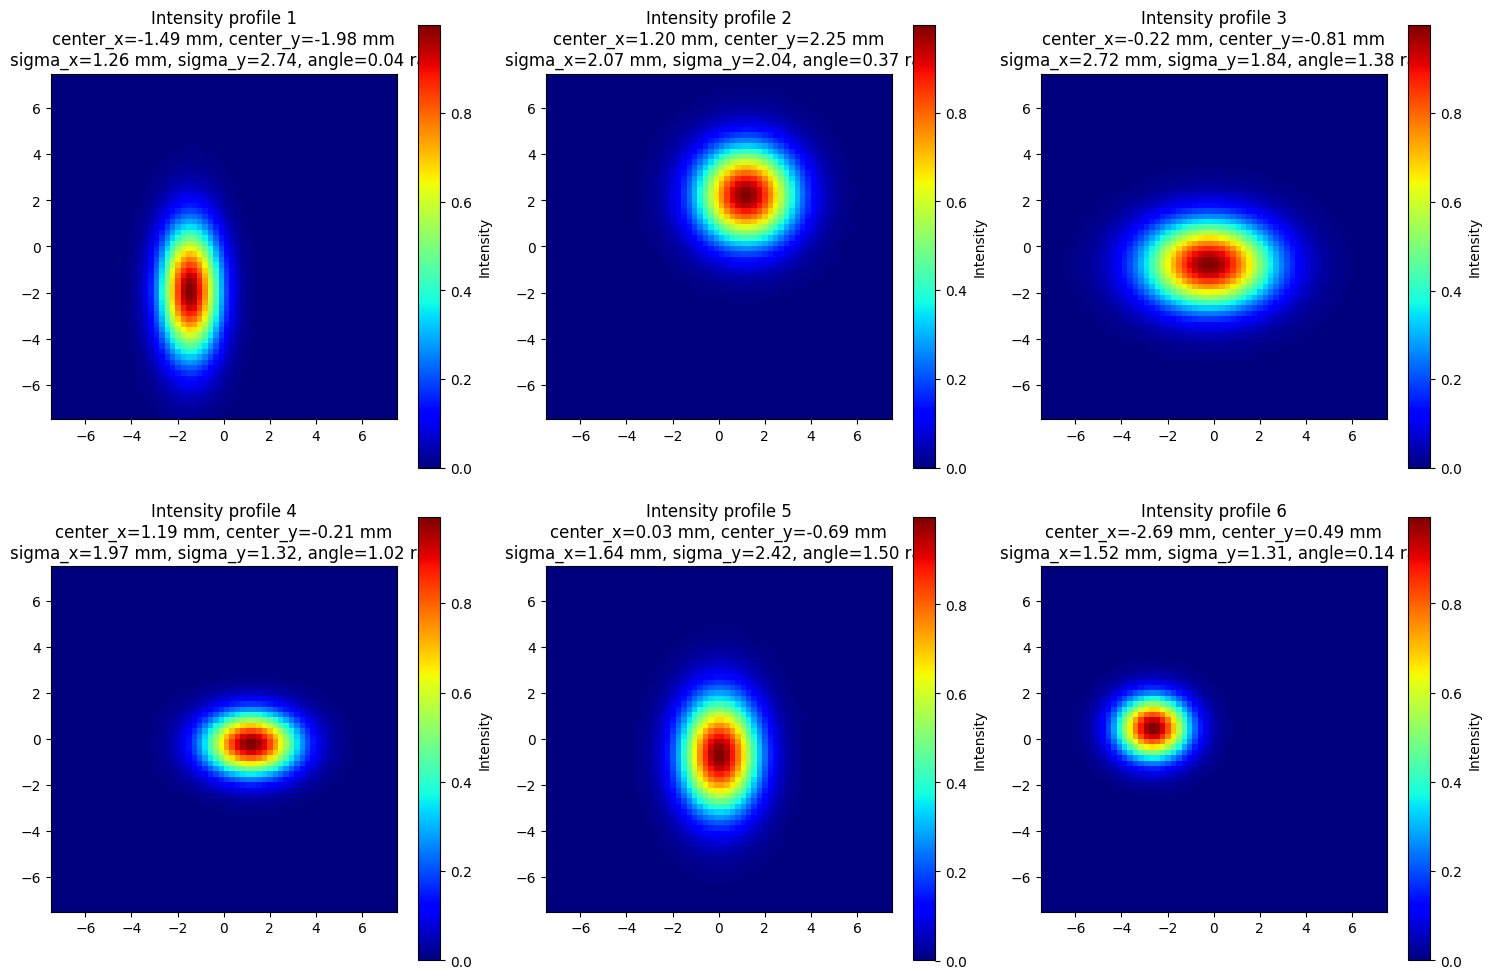

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import LightPipes as lp
from tqdm import tqdm

def generate_intensity_profiles(num_images, output_file_name):
    # Define parameters for the simulation
    size = 15 * lp.mm  # Size of the grid
    wavelength = 410 * lp.nm  # Wavelength of the laser
    N = 64  # Number of grid points

    # Create an initial Gaussian beam with a larger radius
    R = 3 * lp.mm  # Radius of the beam
    F = lp.Begin(size, wavelength, N)
    F = lp.CircAperture(R, 0, 0, F)  # Centered aperture
    F = lp.GaussBeam(F, w0=0.5*lp.mm)

    # Initialize arrays to store intensity matrices and parameters
    intensity_matrices = np.zeros((num_images, N, N))
    parameters = np.zeros((num_images, 5))

    # Loop to generate and save different intensity profiles
    for i in tqdm(range(num_images), desc="Generating intensity profiles"):
        # Randomize parameters
        center_x = np.random.uniform(-3, 3) * lp.mm
        center_y = np.random.uniform(-3, 3) * lp.mm
        sigma_x = np.random.uniform(1, 3) * lp.mm
        sigma_y = np.random.uniform(1, 3) * lp.mm
        angle_ = np.random.uniform(0, np.pi/2)  # Angle of rotation

        ellipticity = np.random.uniform(75, 100)

        # Store parameters
        parameters[i] = [center_x / lp.mm, -center_y / lp.mm, sigma_x / lp.mm, sigma_y / lp.mm, angle_]

        # Apply a non-symmetric intensity modulation to the Gaussian beam
        x, y = np.meshgrid(np.linspace(-size/2, size/2, N), np.linspace(-size/2, size/2, N))

        # Rotate coordinates around the center
        #x_rot = (x - center_x) * np.cos(angle_) - (y - center_y) * np.sin(angle_) + center_x
        #y_rot = (x - center_x) * np.sin(angle_) + (y - center_y) * np.cos(angle_) + center_y

        x_rot = x
        y_rot = y

        # Gaussian intensity distribution with elliptical shape
        gaussian = np.exp(-((x_rot - center_x)**2 / sigma_x**2 + (y_rot - center_y)**2 / sigma_y**2))

        # Add perturbation to simulate ellipticity changes
        """
        if ellipticity < 100:
            perturbation_strength = (100 - ellipticity) / 100
            radius = np.sqrt((x_rot - center_x)**2 + (y_rot - center_y)**2)
            angle_grid = np.arctan2(y_rot - center_y, x_rot - center_x)

            # Introduce random phases
            phase1 = np.random.uniform(0, 2 * np.pi)
            phase2 = np.random.uniform(0, 2 * np.pi)
            phase3 = np.random.uniform(0, 2 * np.pi)

            perturbation = (perturbation_strength *
                            (1 * np.sin(1 * angle_grid + phase1) +
                             0.3 * np.sin(2 * angle_grid + phase2) +
                             0.2 * np.sin(3 * angle_grid + phase3)) *
                            np.exp(-radius / (2 * sigma)))
            gaussian += perturbation
          """

        # Clip values to ensure they are within the valid range
        gaussian = np.clip(gaussian, 0, 1)

        F_mod = lp.SubIntensity(gaussian, F)

        # Convert the result to intensity
        I = lp.Intensity(0, F_mod)

        # Store the intensity matrix
        intensity_matrices[i] = I

    # Save the intensity matrices and parameters to a .npz file
    np.savez(output_file_name+'.npz', intensity_matrices=intensity_matrices, parameters=parameters)

    # Plot a few intensity profiles to visualize
    plt.figure(figsize=(15, 10))

    for i in range(min(6, num_images)):
        params = parameters[i]
        plt.subplot(2, 3, i+1)
        plt.imshow(intensity_matrices[i], extent=[-size/2/lp.mm, size/2/lp.mm, -size/2/lp.mm, size/2/lp.mm], cmap='jet')
        plt.title(f'Intensity profile {i+1}\n'
                  f'center_x={params[0]:.2f} mm, center_y={params[1]:.2f} mm\n'
                  f'sigma_x={params[2]:.2f} mm, sigma_y={params[3]:.2f}, angle={params[4]:.2f} rad')
        plt.colorbar(label='Intensity')

    plt.tight_layout()
    plt.show()

# Example usage:
generate_intensity_profiles(1000, 'intensity_matrices_with_params')
generate_intensity_profiles(1000, 'eval_intensity_matrices_with_params')



### Importa dataset en .npz y crea dataframe con imágenes + 5 parámetros (centro_x, centro_y, sigma_x, sigma_y y ángulo)

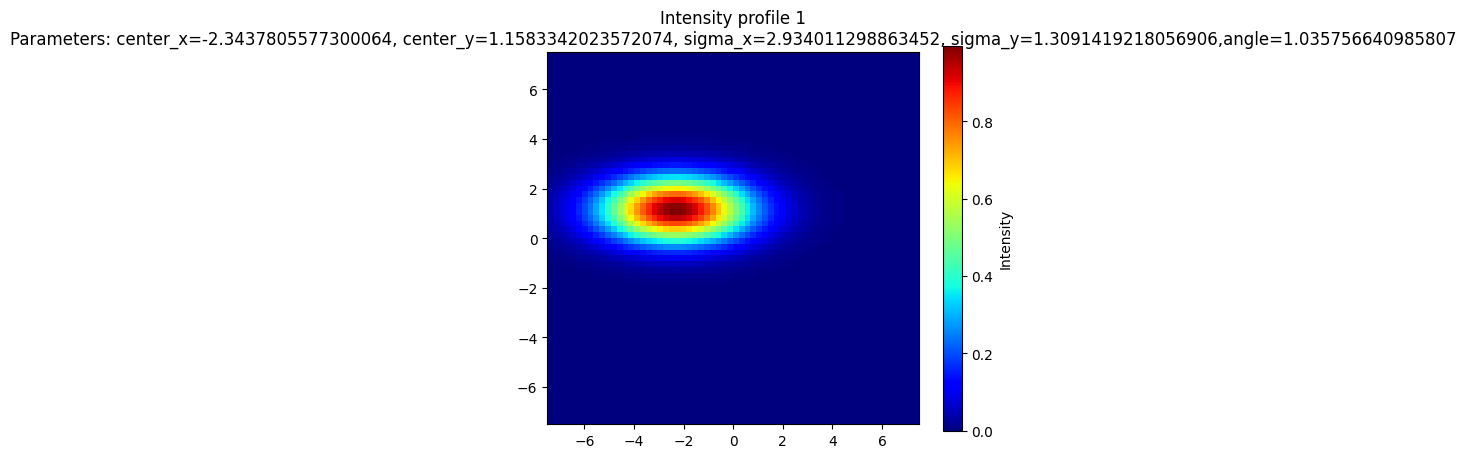

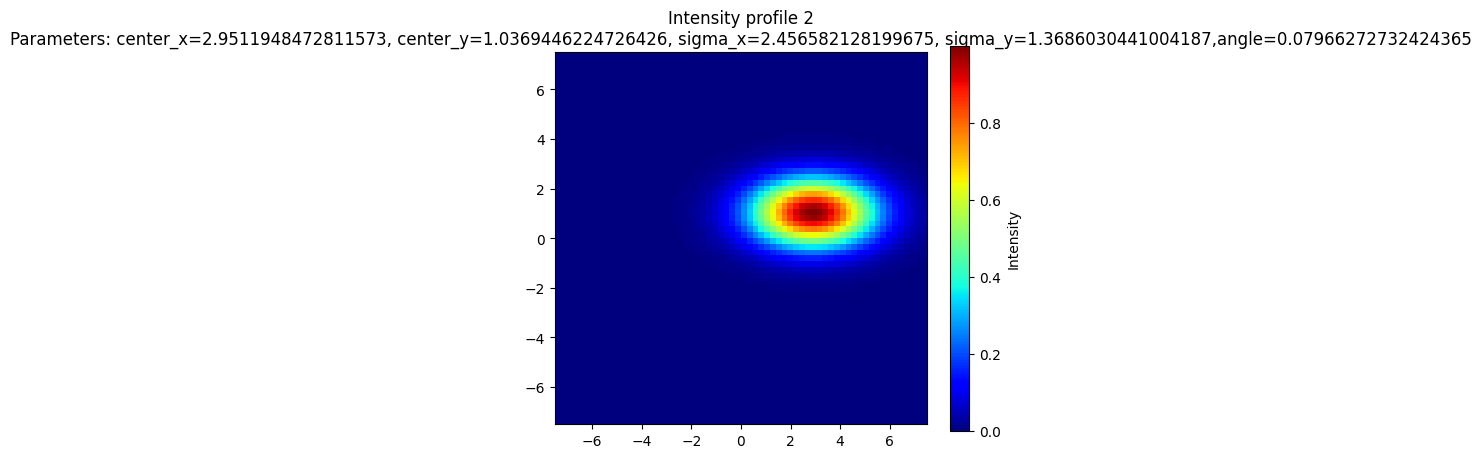

array([-2.34378056,  1.1583342 ,  2.9340113 ,  1.30914192,  1.03575664])

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo .npz
data = np.load('intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Aplanar las matrices de intensidad para almacenarlas en el DataFrame
flattened_intensity_matrices = intensity_matrices.reshape(intensity_matrices.shape[0], -1)

# Crear un DataFrame para las matrices de intensidad y los parámetros
columns = [f'pixel_{i}' for i in range(flattened_intensity_matrices.shape[1])]
df_intensity = pd.DataFrame(flattened_intensity_matrices, columns=columns)

# Añadir las columnas de los parámetros al DataFrame
df_intensity['center_x'] = parameters[:, 0]
df_intensity['center_y'] = parameters[:, 1]
df_intensity['sigma_x'] = parameters[:, 2]
df_intensity['sigma_y'] = parameters[:, 3]
df_intensity['angle'] = parameters[:, 4]

# Mostrar las primeras filas del DataFrame
#print(df_intensity.head())

# Visualizar las primeras dos imágenes con sus parámetros
for i in range(2):
    intensity_matrix = intensity_matrices[i]
    params = df_intensity.iloc[i][['center_x', 'center_y', 'sigma_x', 'sigma_y', 'angle']]

    plt.figure(figsize=(6, 5))
    plt.imshow(intensity_matrix, cmap='jet', extent=[-size/2/lp.mm, size/2/lp.mm, -size/2/lp.mm, size/2/lp.mm])
    plt.title(f'Intensity profile {i+1}\nParameters: center_x={params["center_x"]}, center_y={params["center_y"]}, sigma_x={params["sigma_x"]}, sigma_y={params["sigma_y"]},angle={params["angle"]}')
    plt.colorbar(label='Intensity')
    plt.show()

df_intensity.head()
parameters[0]

### Entrenamiento CNN

Epoch 1/80
100/100 [==============================] - 3s 8ms/step - loss: 0.1183 - mae: 0.2820 - val_loss: 0.1021 - val_mae: 0.2695
Epoch 2/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0915 - mae: 0.2523 - val_loss: 0.0817 - val_mae: 0.2404
Epoch 3/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0784 - mae: 0.2303 - val_loss: 0.0555 - val_mae: 0.1955
Epoch 4/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0753 - mae: 0.2232 - val_loss: 0.0520 - val_mae: 0.1849
Epoch 5/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0649 - mae: 0.2047 - val_loss: 0.0554 - val_mae: 0.1897
Epoch 6/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0591 - mae: 0.1968 - val_loss: 0.0491 - val_mae: 0.1720
Epoch 7/80
100/100 [==============================] - 1s 6ms/step - loss: 0.0560 - mae: 0.1898 - val_loss: 0.0521 - val_mae: 0.1813
Epoch 8/80
100/100 [==============================] - 1s 6ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


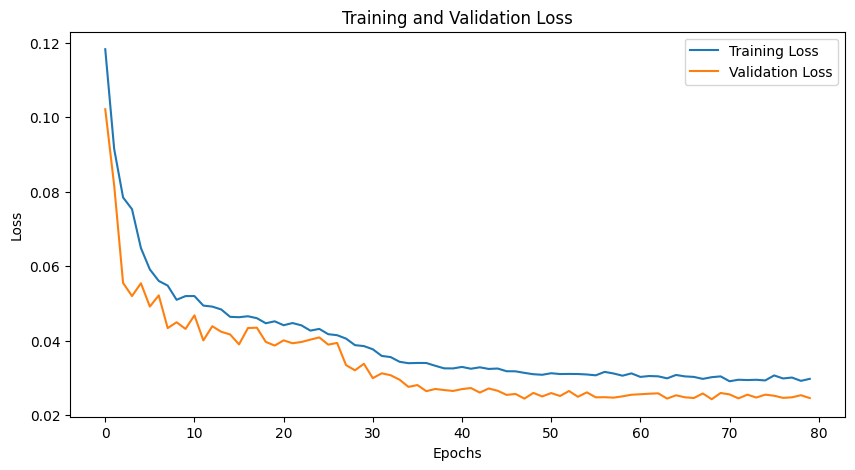

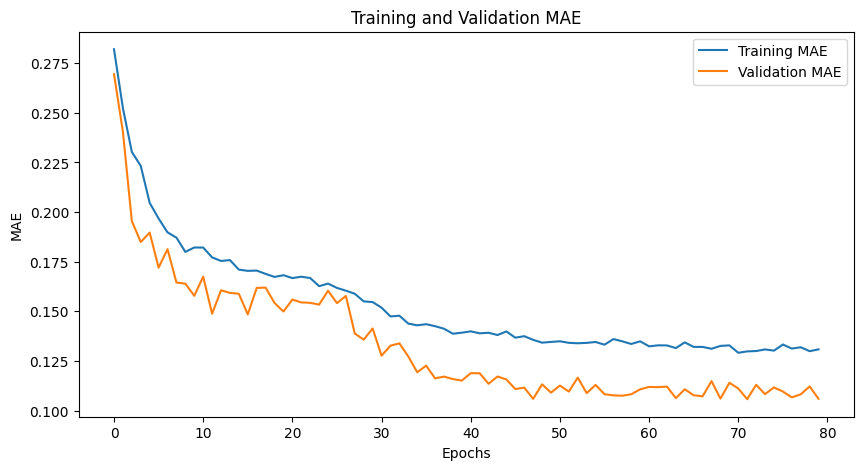

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Cargar el archivo .npz
data = np.load('intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Normalizar las imágenes
intensity_matrices = intensity_matrices / np.max(intensity_matrices)

# Normalizar los parámetros
parameters[:, 0] = (parameters[:, 0] + 3) / 6  # center_x normalizado entre 0 y 1
parameters[:, 1] = (parameters[:, 1] + 3) / 6  # center_y normalizado entre 0 y 1
parameters[:, 2] = (parameters[:, 2] - 1) / 2  # sigma_x normalizado entre 0 y 1
parameters[:, 3] = (parameters[:, 3] - 1) / 2  # sigma_y normalizado entre 0 y 1
parameters[:, 4] = (parameters[:, 4]) / (np.pi/2)  # angle normalizado entre 0 y 1

# Dividir el conjunto de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(intensity_matrices, parameters, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que sean compatibles con la entrada de la CNN
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Definir el modelo de la CNN más complejo
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(1024, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(5)  # 5 parámetros a predecir
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val), batch_size=8)

# Guardar el modelo entrenado
model.save('cnn_model.h5')

# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar el MAE de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### 1era Evaluacion del modelo con dataset de evaluación



7/7 [==============================] - 0s 3ms/step


<ipython-input-84-1426ad0f7db8>:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


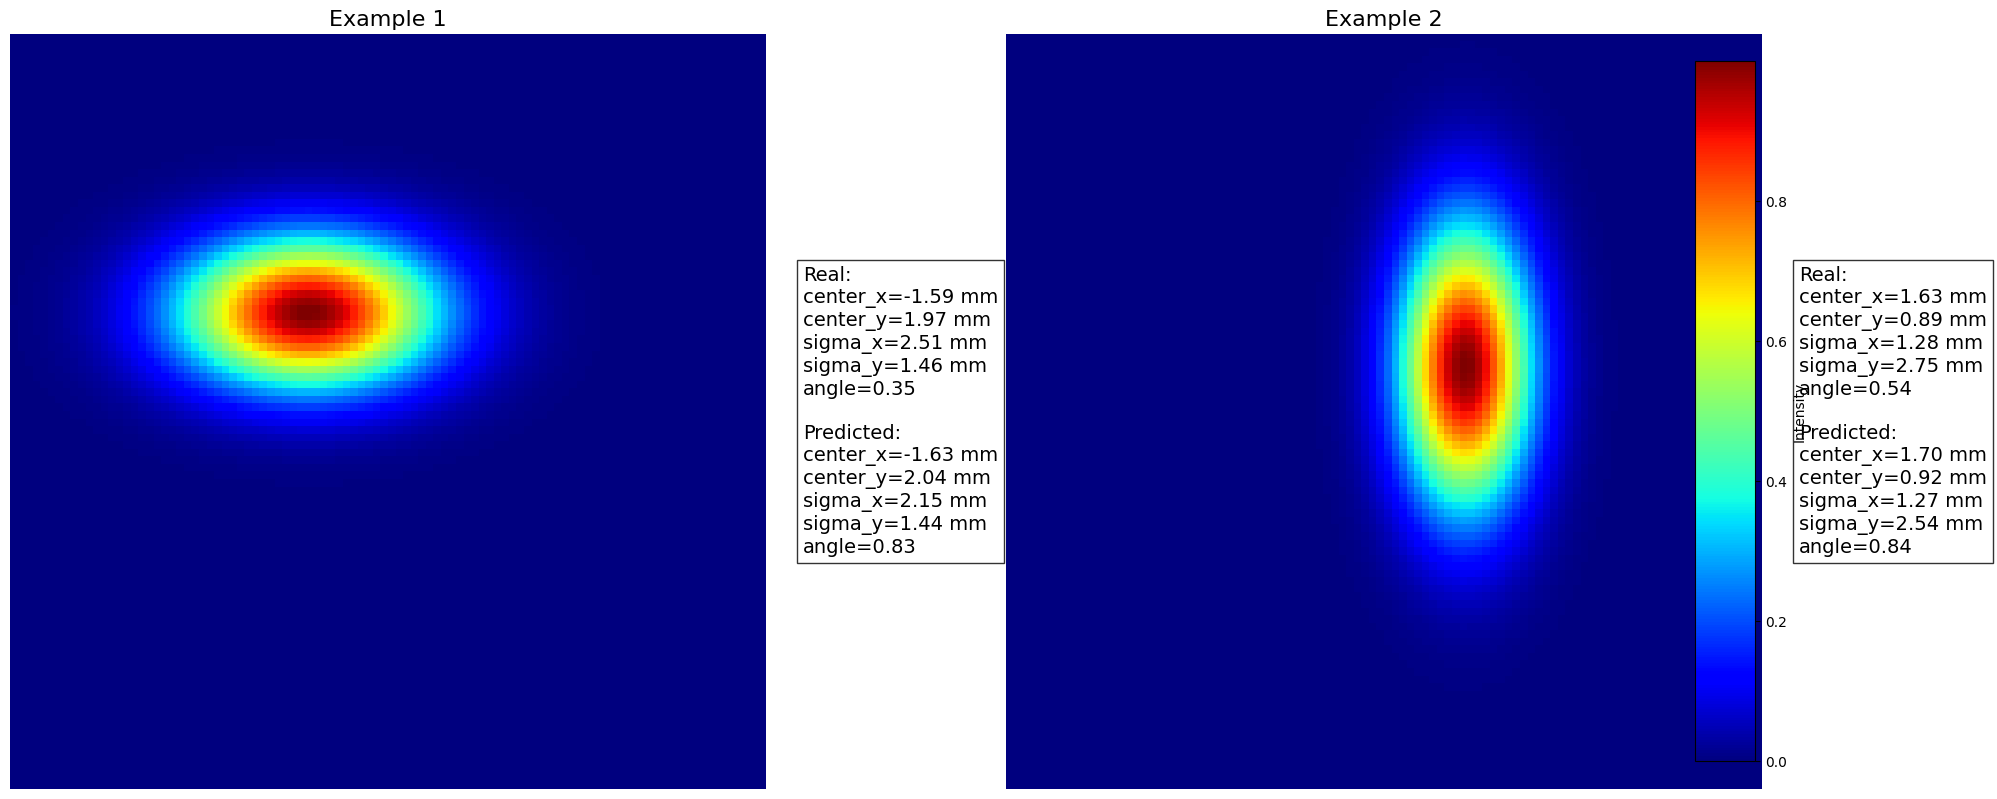

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Cargar el archivo .npz
data = np.load('eval_intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Normalizar las imágenes
intensity_matrices = intensity_matrices / np.max(intensity_matrices)

# Normalizar los parámetros
parameters[:, 0] = (parameters[:, 0] + 3) / 6  # center_x normalizado entre 0 y 1
parameters[:, 1] = (parameters[:, 1] + 3) / 6  # center_y normalizado entre 0 y 1
parameters[:, 2] = (parameters[:, 2] - 1) / 2  # sigma_x normalizado entre 0 y 1
parameters[:, 3] = (parameters[:, 3] - 1) / 2  # sigma_y normalizado entre 0 y 1
parameters[:, 4] = (parameters[:, 4]) / (np.pi/2) # angle normalizado entre 0 y 1

# Dividir el conjunto de datos en entrenamiento y validación
_, X_val, _, y_val = train_test_split(intensity_matrices, parameters, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que sean compatibles con la entrada de la CNN
X_val = np.expand_dims(X_val, axis=-1)

# Cargar el modelo entrenado
model = tf.keras.models.load_model('cnn_model.h5')

# Evaluar el modelo en el conjunto de validación
predictions = model.predict(X_val)

# Desnormalizar las predicciones y los valores reales
predictions[:, 0] = predictions[:, 0] * 6 - 3  # Desnormalizar center_x
predictions[:, 1] = predictions[:, 1] * 6 - 3  # Desnormalizar center_y
predictions[:, 2] = predictions[:, 2] * 2 + 1  # Desnormalizar sigma_x
predictions[:, 3] = predictions[:, 3] * 2 + 1  # Desnormalizar sigma_y
predictions[:, 4] = predictions[:, 4] * (np.pi/2)  # Desnormalizar angle

y_val[:, 0] = y_val[:, 0] * 6 - 3  # Desnormalizar center_x
y_val[:, 1] = y_val[:, 1] * 6 - 3  # Desnormalizar center_y
y_val[:, 2] = y_val[:, 2] * 2 + 1  # Desnormalizar sigma_x
y_val[:, 3] = y_val[:, 3] * 2 + 1  # Desnormalizar sigma_y
y_val[:, 4] = y_val[:, 4] * (np.pi/2)  # Desnormalizar angle

# Seleccionar algunos ejemplos para mostrar
num_examples = 2
indices = np.random.choice(np.arange(X_val.shape[0]), num_examples, replace=False)

# Mostrar las imágenes, los valores reales y los valores predichos
fig, axes = plt.subplots(1, num_examples, figsize=(20, 10))

for i, idx in enumerate(indices):
    intensity_matrix = X_val[idx].squeeze()
    real_params = y_val[idx]
    predicted_params = predictions[idx]

    ax = axes[i]
    im = ax.imshow(intensity_matrix, cmap='jet', extent=[-size/2/lp.mm, size/2/lp.mm, -size/2/lp.mm, size/2/lp.mm])
    ax.set_title(f'Example {i + 1}', fontsize=16)
    ax.axis('off')

    textstr = (f'Real:\n'
               f'center_x={real_params[0]:.2f} mm\n'
               f'center_y={real_params[1]:.2f} mm\n'
               f'sigma_x={real_params[2]:.2f} mm\n'
               f'sigma_y={real_params[3]:.2f} mm\n'
               f'angle={real_params[4]:.2f}\n\n'
               f'Predicted:\n'
               f'center_x={predicted_params[0]:.2f} mm\n'
               f'center_y={predicted_params[1]:.2f} mm\n'
               f'sigma_x={predicted_params[2]:.2f} mm\n'
               f'sigma_y={predicted_params[3]:.2f} mm\n'
               f'angle={predicted_params[4]:.2f}')

    # Poner el texto a la derecha del gráfico
    ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Intensity')

plt.tight_layout()
plt.show()


### Resultados: representación prediccion vs referencia  +  histograma error

7/7 [==============================] - 0s 3ms/step
MAE for center_x: 0.29
MAE for center_y: 0.32
MAE for sigma_x: 0.15
MAE for sigma_y: 0.13
MAE for angle: 0.43


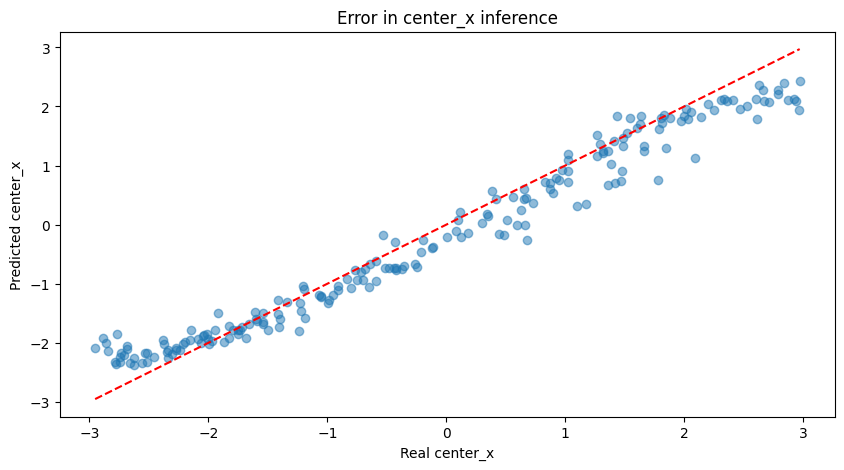

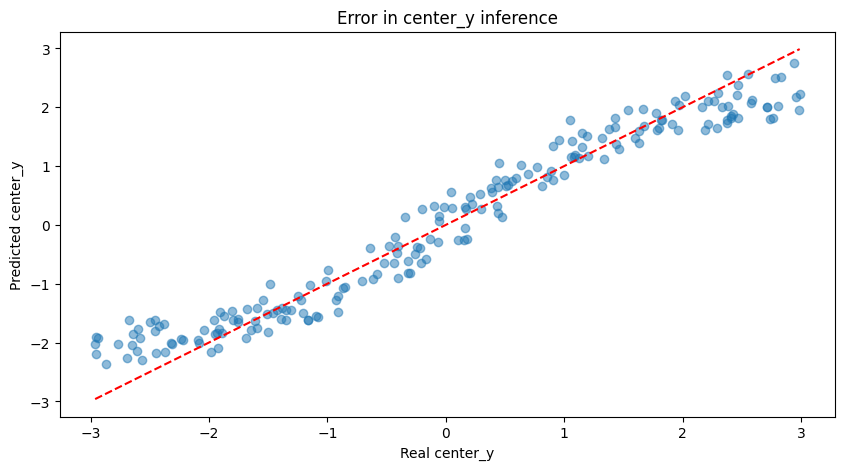

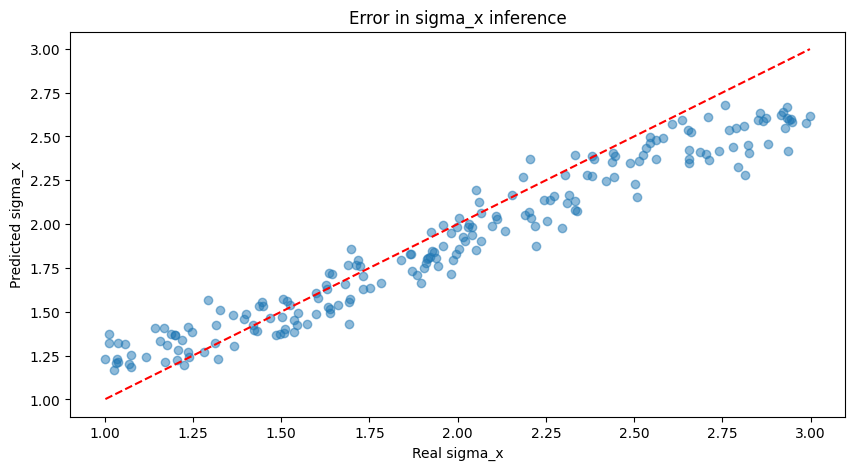

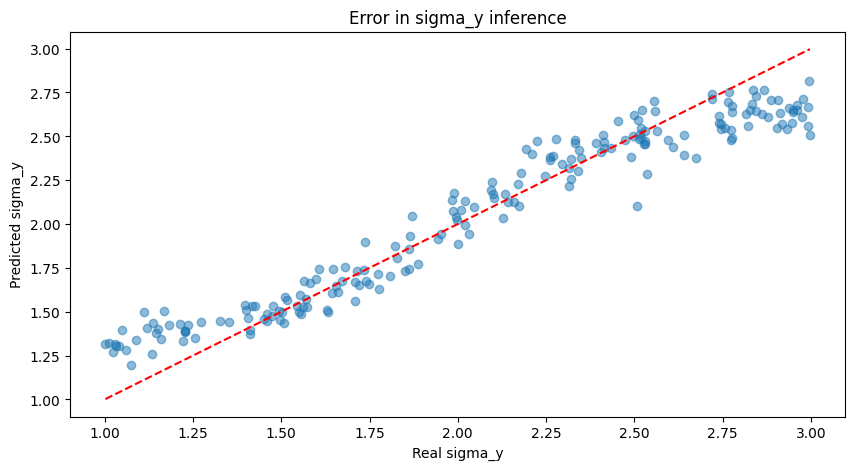

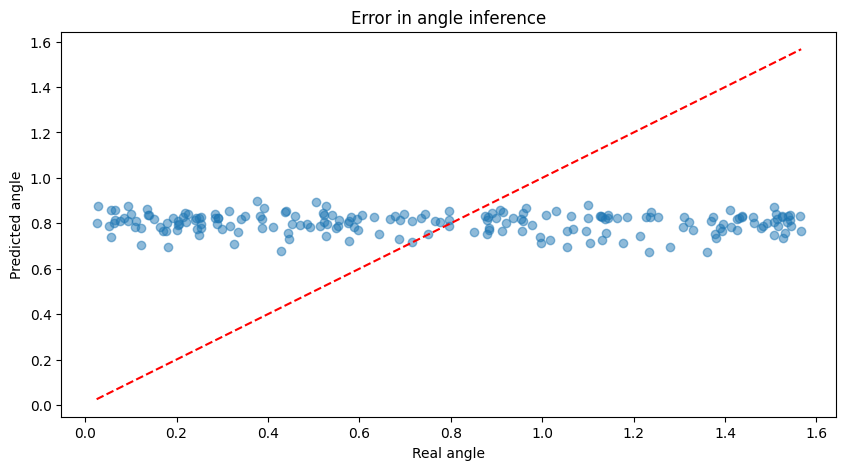

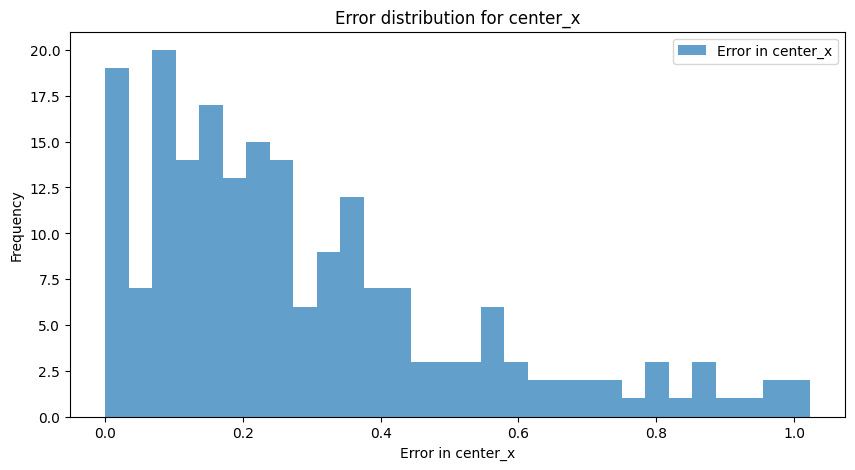

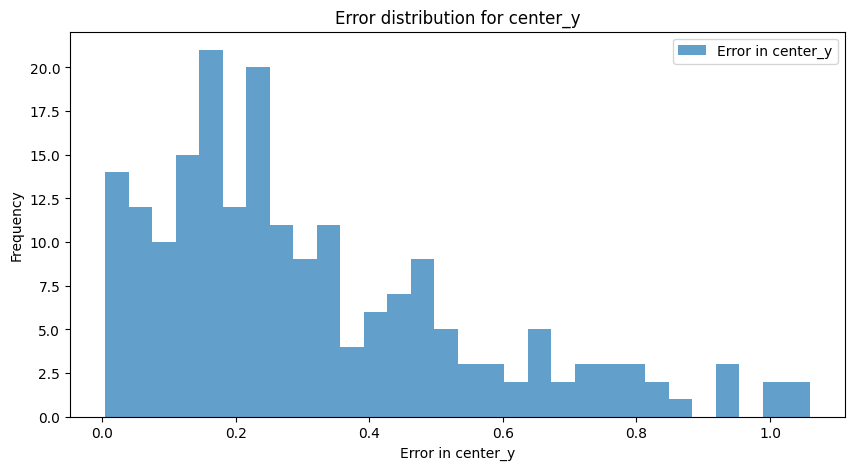

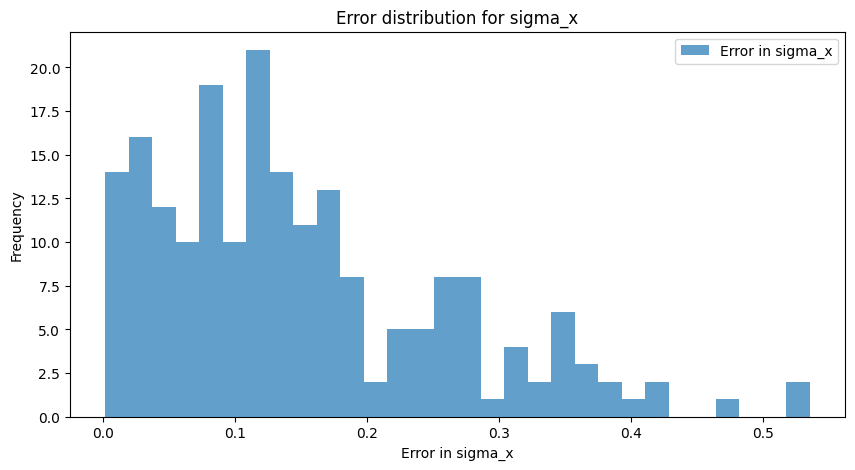

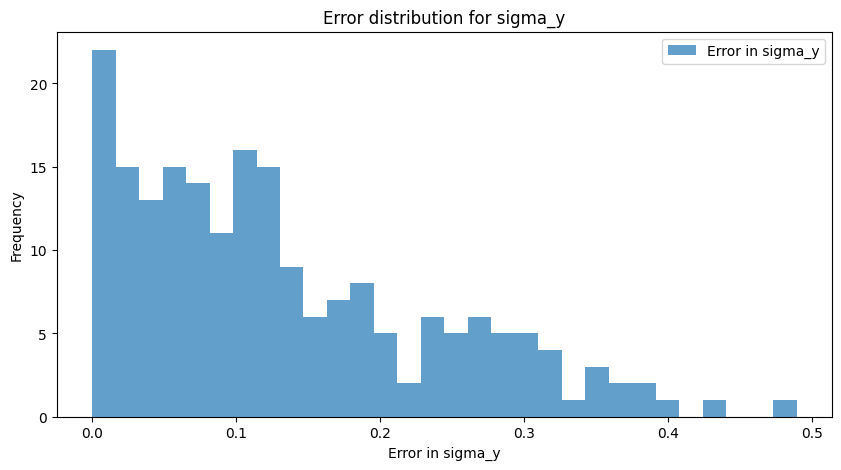

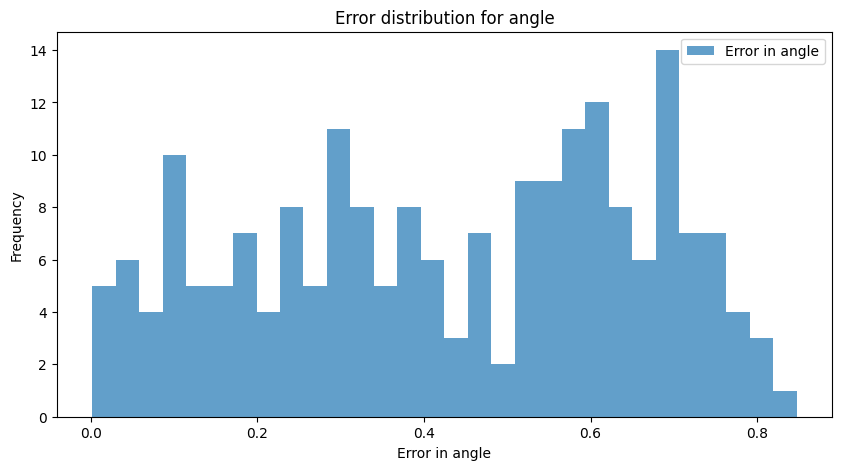

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Cargar el archivo .npz
data = np.load('eval_intensity_matrices_with_params.npz')

# Extraer las matrices de intensidad y los parámetros
intensity_matrices = data['intensity_matrices']
parameters = data['parameters']

# Normalizar las imágenes
intensity_matrices = intensity_matrices / np.max(intensity_matrices)

# Normalizar los parámetros
parameters[:, 0] = (parameters[:, 0] + 3) / 6  # center_x normalizado entre 0 y 1
parameters[:, 1] = (parameters[:, 1] + 3) / 6  # center_y normalizado entre 0 y 1
parameters[:, 2] = (parameters[:, 2] - 1) / 2  # sigma_x normalizado entre 0 y 1
parameters[:, 3] = (parameters[:, 3] - 1) / 2  # sigma_y normalizado entre 0 y 1
parameters[:, 4] = (parameters[:, 4]) / (np.pi/2)  # angle normalizado entre 0 y 1

# Dividir el conjunto de datos en entrenamiento y validación
_, X_val, _, y_val = train_test_split(intensity_matrices, parameters, test_size=0.2, random_state=42)

# Expandir las dimensiones de las imágenes para que sean compatibles con la entrada de la CNN
X_val = np.expand_dims(X_val, axis=-1)

# Cargar el modelo entrenado
model = tf.keras.models.load_model('cnn_model.h5')

# Evaluar el modelo en el conjunto de validación
predictions = model.predict(X_val)

# Desnormalizar las predicciones y los valores reales
predictions[:, 0] = predictions[:, 0] * 6 - 3  # Desnormalizar center_x
predictions[:, 1] = predictions[:, 1] * 6 - 3  # Desnormalizar center_y
predictions[:, 2] = predictions[:, 2] * 2 + 1  # Desnormalizar sigma_x
predictions[:, 3] = predictions[:, 3] * 2 + 1  # Desnormalizar sigma_y
predictions[:, 4] = predictions[:, 4] * (np.pi/2)  # Desnormalizar angle

y_val[:, 0] = y_val[:, 0] * 6 - 3  # Desnormalizar center_x
y_val[:, 1] = y_val[:, 1] * 6 - 3  # Desnormalizar center_y
y_val[:, 2] = y_val[:, 2] * 2 + 1  # Desnormalizar sigma_x
y_val[:, 3] = y_val[:, 3] * 2 + 1  # Desnormalizar sigma_y
y_val[:, 4] = y_val[:, 4] * (np.pi/2)  # Desnormalizar angle

# Calcular el error absoluto medio para cada parámetro
mae_center_x = mean_absolute_error(y_val[:, 0], predictions[:, 0])
mae_center_y = mean_absolute_error(y_val[:, 1], predictions[:, 1])
mae_sigma_x = mean_absolute_error(y_val[:, 2], predictions[:, 2])
mae_sigma_y = mean_absolute_error(y_val[:, 3], predictions[:, 3])
mae_angle = mean_absolute_error(y_val[:, 4], predictions[:, 4])

print(f'MAE for center_x: {mae_center_x:.2f}')
print(f'MAE for center_y: {mae_center_y:.2f}')
print(f'MAE for sigma_x: {mae_sigma_x:.2f}')
print(f'MAE for sigma_y: {mae_sigma_y:.2f}')
print(f'MAE for angle: {mae_angle:.2f}')

# Graficar los errores de inferencia para cada parámetro
parameters = ['center_x', 'center_y', 'sigma_x', 'sigma_y', 'angle']
for i, param in enumerate(parameters):
    plt.figure(figsize=(10, 5))
    plt.scatter(y_val[:, i], predictions[:, i], alpha=0.5)
    plt.plot([y_val[:, i].min(), y_val[:, i].max()], [y_val[:, i].min(), y_val[:, i].max()], 'r--')
    plt.xlabel(f'Real {param}')
    plt.ylabel(f'Predicted {param}')
    plt.title(f'Error in {param} inference')
    plt.show()

# Graficar el error absoluto para cada parámetro
for i, param in enumerate(parameters):
    errors = np.abs(y_val[:, i] - predictions[:, i])
    plt.figure(figsize=(10, 5))
    plt.hist(errors, bins=30, alpha=0.7, label=f'Error in {param}')
    plt.xlabel(f'Error in {param}')
    plt.ylabel('Frequency')
    plt.title(f'Error distribution for {param}')
    plt.legend()
    plt.show()


Conclusión ha funcionado bastante bien, a excepción de la elipticidad. Dado que la elipticidad se genera a partir de un número aleatorio que será una perturbación en forma de "fase de sinusoide" que se añade a la ecuación de la gaussiana. Ésta no se puede predecir por ser aleatoria en un rango, si se guardara el valor resultante en lugar de el rango de aleatoriedad, sí que se podría inferir